# CAPM Assignment - Securities Market Line

### Benjamin Danziger

In [1]:
# Import modules
import yfinance as yf
import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import fredpy as fp
import os

In [2]:
# Set API key for pulling rates data later on
fp.api_key = os.getenv("FRED_API_KEY")

In [3]:
# Set start and end dates
years_lookback = 2
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=365 * years_lookback)

### Step 1: Collect price data

In [4]:
stock_symbols = {
    "market": ["^SPX"],
    "tech": ["NVDA", "AAPL", "AMZN", "META"],
    "financials": ["JPM", "BAC", "GS", "MS"],
    "energy": ["XOM", "CVX", "COP", "EOG"],
    "healthcare": ["LLY", "UNH", "JNJ", "ABBV"],
    "industrials": ["GE", "CAT", "DE", "LMT"],
}

In [5]:
# Use tickers to get data
stock_data = {
    sector: yf.download(stock_symbols[sector], start=start_date, end=end_date)[
        "Adj Close"
    ].tz_localize(
        None
    )  # Ignore timezones as this creates problems later on with FRED data
    for sector in stock_symbols.keys()
}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


### Step 2: Define some CAPM variables and functions

In [6]:
two_year = fp.series("DGS2").data.tz_localize(None) / 100  # Two-year rates
risk_free_rate = two_year.iloc[-1]  # Risk free rate today
daily_risk_free_rate = risk_free_rate / 365  # Daily risk free rate
excess_daily_mkt_return = (
    stock_data["market"]["^SPX"].pct_change().dropna() - daily_risk_free_rate
)  # Daily return of market over that of daily risk free rate
average_daily_mkt_return = (
    stock_data["market"]["^SPX"].pct_change().mean()
)  # average daily market return

In [7]:
def get_capm(stock_return: pd.Series, *regressors: pd.Series) -> pd.Series:
    """
    Get CAPM model results

    INPUT:
    stock_returns: pd.Series - Excess daily stock returns over that of the market

    *regressors: pd.Series - arbitrary number of regressors. At least one of them should be
    daily excess return of the market over the risk free rate

    OUTPUT:
    model results: pd.Series - Model intercept, coefficients and R squared
    """
    # First lets get a common index
    index = stock_return.dropna().index
    for regressor in regressors:
        index = index.intersection(regressor.dropna().index)
    # Now we can use this index and create a df that will hold the data of the independant variables
    x_df = pd.concat(regressors, axis=1)
    X = sm.add_constant(x_df.reindex(index))
    # Fit the model
    model = sm.OLS(stock_return.loc[index], X).fit()
    # Get the R squared
    rsquared = model.__getattribute__("rsquared")
    # Combine results and return
    result = model.params
    result["rsquared"] = rsquared
    return result

In [8]:
def get_regression_table(stock_data: dict[str, pd.DataFrame], *regressors: pd.Series) -> pd.DataFrame:
    """
    This will serve as a very useful function that takes stock data (in the form of stock_data defined above)
    and regresses excess daily stock returns for each stock on an arbitrary number of regressors (e.g. excess
    market returns). It is useful as it allows us to add as many factors as we like.

    INPUT:
    stock_data: dict[str, pd.DataFrame - must be in the form of `stock_data` defined above.
    *regressors: pd.Series - The factors we want to regress. Make sure they are all stationary

    OUTPUT:
    regression table: pd.DataFrame - table with stocks on y axis and model results on x axis
    """
    # Create dict to save results
    capm = {}
    # First we need to iterate over each stock
    for sector, data in stock_data.items():
        for stock in data.columns:
            # Calculate the excess daily return of the stock
            actual_daily_return = stock_data[sector][stock].pct_change().dropna()
            excess_daily_stock_return = actual_daily_return - daily_risk_free_rate
            # Now we have the data we need to fit the CAPM model - we can do that with the function we defined
            # in the previous cell
            capm_results = get_capm(excess_daily_stock_return, *regressors)
            alpha = capm_results.iloc[
                0
            ]  # The alpha (intercept) will always be the 0th element
            rsquared = capm_results.iloc[-1]  # The R squared is the final element
            betas = capm_results.iloc[
                1 : len(capm_results) - 1
            ]  # Betas are all values inbetween first and last element
            annualised_alpha = alpha * 252
            # Use the model beta to calculate the expected daily return of the stock.
            # Becasue we dont know how many betas we might have, we need to build a for loop to handle
            # an arbitrary number of betas
            expected_daily_return = daily_risk_free_rate
            beta_dict = {}
            for i, (beta, regressor) in enumerate(zip(betas, regressors)):
                expected_daily_return += (
                    beta * regressor
                )  # For each beta, we add the product of the beta and
                # factor to the running total of the expected daily return
                beta_dict[f"beta_{i}"] = beta  # Add beta to a dict
            # Now we can save the results of each stock into our results dict
            capm[stock] = {
                "sector": sector.upper(),
                "alpha": annualised_alpha,
                "rsquared": rsquared,
                "MAE": (
                    (actual_daily_return - expected_daily_return - alpha) ** 2
                ).mean(),  # Mean absolute error
                "expected_return": expected_daily_return.mean() * 252,
                "actual_return": actual_daily_return.mean() * 252,
                "undervalued": actual_daily_return.mean()
                > expected_daily_return.mean()  # bool for whether
                # stock is undervalued
            } | beta_dict  # add the beta dict to the results
    capm = pd.DataFrame(capm).T  # Converts results dict into readable df
    # It is slightly annoying that the betas get added to the end of the df.
    # Lets move them to come after the alpha column
    for i in range(len(regressors)):
        beta_to_move = capm[f"beta_{i}"]
        capm.drop(f"beta_{i}", axis=1, inplace=True)
        capm.insert(i + 2, f"beta_{i}", beta_to_move)
    # Because we have the sector col which contains strings, the dtype of the whole df is 'object'
    # This creates complications when doing regressions later on so lets just convert the number
    # cols to dtype = float
    for col in capm.columns[1:]:
        capm[col] = pd.to_numeric(capm[col]).round(4)  # 4 decimal places will do

    return capm

### Step 3: Regress excess stock returns on excess market returns and collect model results

In [9]:
basic_capm_results = get_regression_table(stock_data, excess_daily_mkt_return)

In [10]:
basic_capm_results

,sector,alpha,beta_0,rsquared,MAE,expected_return,actual_return,undervalued
^SPX,MARKET,-0.0000,1.0000,1.0000,0.0000,0.2146,0.2146,False
AAPL,TECH,-0.0094,1.1966,0.4893,0.0001,0.2513,0.2419,False
AMZN,TECH,0.0321,1.6000,0.4759,0.0002,0.3265,0.3586,True
META,TECH,0.6575,1.6790,0.3386,0.0004,0.3412,0.9987,True
NVDA,TECH,0.8468,2.4142,0.4102,0.0006,0.4784,1.3252,True
BAC,FINANCIALS,-0.0689,0.9424,0.2827,0.0002,0.2039,0.1349,False
GS,FINANCIALS,0.0510,0.9502,0.3288,0.0001,0.2053,0.2563,True
JPM,FINANCIALS,0.1675,0.7509,0.2576,0.0001,0.1681,0.3356,True
MS,FINANCIALS,0.0206,1.0404,0.3365,0.0002,0.2221,0.2427,True
COP,ENERGY,-0.1586,0.5691,0.0865,0.0003,0.1342,-0.0243,False


In [11]:
basic_capm_results.groupby("sector").mean()

,alpha,beta_0,rsquared,MAE,expected_return,actual_return,undervalued
sector,,,,,,,
ENERGY,-0.112450,0.553925,0.098850,0.000250,0.13140,0.018975,0.00
FINANCIALS,0.042550,0.920975,0.301400,0.000150,0.19985,0.242375,0.75
HEALTHCARE,0.100950,0.300300,0.037125,0.000175,0.08410,0.185075,0.50
INDUSTRIALS,0.142625,0.724175,0.181950,0.000175,0.16315,0.305775,0.75
MARKET,0.000000,1.000000,1.000000,0.000000,0.21460,0.214600,0.00
TECH,0.381750,1.722450,0.428500,0.000325,0.34935,0.731100,0.75


These results show that a basic CAPM model, while a good start, has limited use in modelling stock returns. Average R squared across industries does not exceed 0.43. 

As we would expect, tech has the highest beta, with an average level of 1.72, indicating significant responsiveness of tech returns to broader market returns. NVDA has a very high beta of 2.41. 

Financials have a beta closer to one, showing these stocks pretty much track the market. This relationship represents how performance of the financials sector is very much linked to the performance of the wider economy, as measured by 
S&P 500 returns. 

Healthcare stocks have a very low beta, averaging 0.3. This, in part, represents how healthcare stock returns depend on healthcare research which is unrelated to many other factors that drive stock returns. 

### Step 4: Plot SML and compare to actual results

In [12]:
# Define a colour dict so we can assign colours to stock plots based on their sector
colour_dict = {
    "market": "yellow",
    "tech": "red",
    "financials": "purple",
    "energy": "green",
    "healthcare": "orange",
    "industrials": "brown",
}
# get list of colours to plot
colours = [colour_dict[sector.lower()] for sector in basic_capm_results["sector"]]

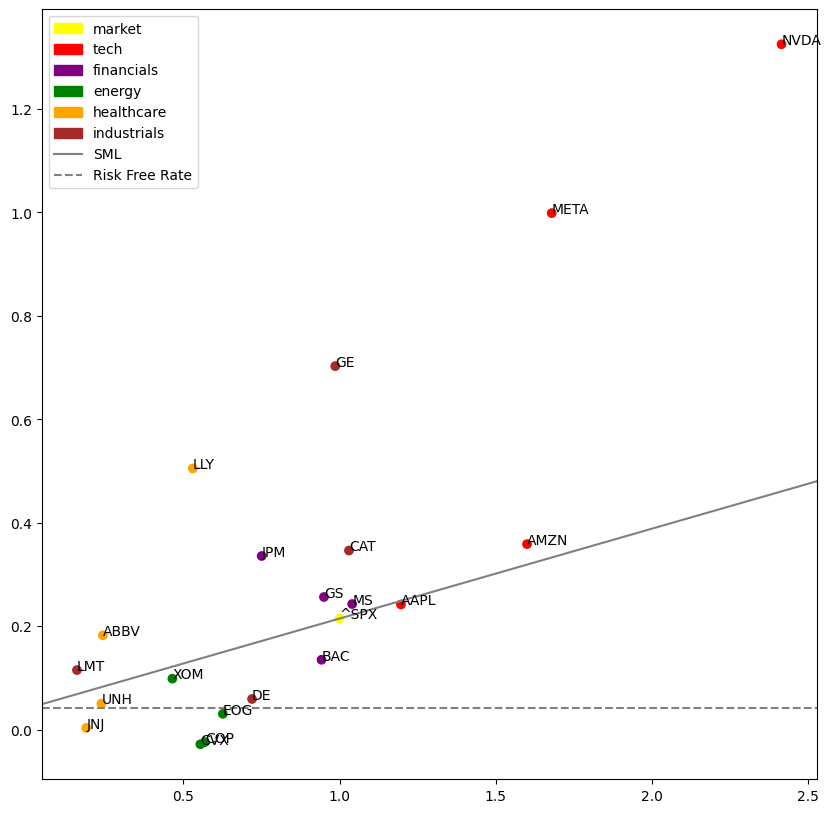

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))  # init figure
# Scatter with actual returns
ax.scatter(
    basic_capm_results["beta_0"], basic_capm_results["actual_return"], c=colours
)  # c = colours assigns sector based colour
# Annotate the stock tickers onto the plot
for i, stock in enumerate(basic_capm_results.index):
    ax.annotate(
        stock,
        (
            basic_capm_results["beta_0"].iloc[i],
            basic_capm_results["actual_return"].iloc[i],
        ),
    )
# Plot SML
sml_line = ax.axline(
    (basic_capm_results["beta_0"].iloc[0], average_daily_mkt_return * 252),
    slope=(
        (average_daily_mkt_return * 252 - risk_free_rate)
        / basic_capm_results["beta_0"].iloc[0]
    ),
    color="grey",
    label="SML",
)
# Plot risk free rate
risk_free_line = ax.axhline(
    risk_free_rate, linestyle="--", color="grey", label="Risk Free Rate"
)
# Add a legend
legend_handles = [
    mpatches.Patch(color=colour_dict[sector], label=sector) for sector in colour_dict
]
ax.legend(handles=legend_handles + [sml_line, risk_free_line], loc="upper left")

The above plot shows how tech stocks typically sit above the SML, indicating these returns are better than we would expect in a basic CAPM model.

Financials have the next highest beta, and on average, perform above the SML. 

Energy stocks, while having a low beta, also have a very low actual return that sits below the SML. This indicates these stocks are overvalued. 

### Step 5: Add two-year yields as a factor to the CAPM model

In [14]:
yield_change = two_year.diff().dropna()
adfuller(yield_change)[1]

np.float64(7.364337430177647e-30)

In [15]:
two_year_capm = get_regression_table(stock_data, excess_daily_mkt_return, yield_change)

In [16]:
two_year_capm

,sector,alpha,beta_0,beta_1,rsquared,MAE,expected_return,actual_return,undervalued
^SPX,MARKET,0.0000,1.0000,0.0000,1.0000,0.0000,0.2585,0.2146,False
AAPL,TECH,0.0215,1.1852,-1.1736,0.4967,0.0001,0.3050,0.2419,False
AMZN,TECH,-0.0146,1.6182,-1.4626,0.4851,0.0002,0.4057,0.3586,False
META,TECH,0.5700,1.7184,0.3533,0.3490,0.0004,0.4228,0.9987,True
NVDA,TECH,0.9019,2.3884,0.9972,0.4142,0.0006,0.5751,1.3252,True
BAC,FINANCIALS,-0.0528,0.9486,3.1165,0.3123,0.0002,0.2365,0.1349,False
GS,FINANCIALS,0.1266,0.9284,1.5885,0.3405,0.0001,0.2368,0.2563,True
JPM,FINANCIALS,0.2069,0.7527,4.1009,0.3240,0.0001,0.1882,0.3356,True
MS,FINANCIALS,0.0436,1.0266,2.1656,0.3560,0.0002,0.2576,0.2427,False
COP,ENERGY,-0.1442,0.5469,3.5344,0.1153,0.0002,0.1426,-0.0243,False


In [17]:
two_year_capm.groupby("sector").mean()

,alpha,beta_0,beta_1,rsquared,MAE,expected_return,actual_return,undervalued
sector,,,,,,,,
ENERGY,-0.108925,0.533650,2.867225,0.120475,0.000225,0.141725,0.018975,0.00
FINANCIALS,0.081075,0.914075,2.742875,0.333200,0.000150,0.229775,0.242375,0.50
HEALTHCARE,0.109775,0.310975,-0.234550,0.044600,0.000175,0.100525,0.185075,0.50
INDUSTRIALS,0.181050,0.716150,1.526775,0.186450,0.000175,0.188125,0.305775,0.75
MARKET,0.000000,1.000000,0.000000,1.000000,0.000000,0.258500,0.214600,0.00
TECH,0.369700,1.727550,-0.321425,0.436250,0.000325,0.427150,0.731100,0.50


by adding two-year yields, we can see that most industries have a positive relationship with yield changes. a 1 percentage point increase in yields leads to, on average, a 2.87% increase in energy stocks. However, yield rises are also shown to lead to negative returns in healthcare and tech stocks. The p-values of these coefficients have not been checked so they may be statistically insignificant. 

In [24]:
# Difference to last model
two_year_capm.groupby("sector").mean() - basic_capm_results.groupby("sector").mean()

,MAE,actual_return,alpha,beta_0,beta_1,expected_return,rsquared,undervalued
sector,,,,,,,,
ENERGY,-0.000025,0.0,0.003525,-0.020275,NaN,0.010325,0.021625,0.00
FINANCIALS,0.000000,0.0,0.038525,-0.006900,NaN,0.029925,0.031800,-0.25
HEALTHCARE,0.000000,0.0,0.008825,0.010675,NaN,0.016425,0.007475,0.00
INDUSTRIALS,0.000000,0.0,0.038425,-0.008025,NaN,0.024975,0.004500,0.00
MARKET,0.000000,0.0,0.000000,0.000000,NaN,0.043900,0.000000,0.00
TECH,0.000000,0.0,-0.012050,0.005100,NaN,0.077800,0.007750,-0.25


The R squared column shows that adding two-year yields has increased R squared values across the board

### Step 6: Now that we have this function we may as well try some other regressors

In [19]:
# The regressors we try need to be daily data otherwise we will violate the Central Limit Theorem
# as we will have too few observations

# ICE BofA US High Yield Index Option-Adjusted Spread
credit_spread = fp.series("BAMLH0A0HYM2").data.dropna().diff().dropna()

In [20]:
credit_spread_capm = get_regression_table(
    stock_data, excess_daily_mkt_return, yield_change, credit_spread
)
credit_spread_capm

,sector,alpha,beta_0,beta_1,beta_2,rsquared,MAE,expected_return,actual_return,undervalued
^SPX,MARKET,0.0000,1.0000,-0.0000,0.0000,1.0000,0.0000,0.2585,0.2146,False
AAPL,TECH,0.0215,1.2203,-0.8377,0.0066,0.4974,0.0001,0.3050,0.2419,False
AMZN,TECH,-0.0146,1.6186,-1.4585,0.0001,0.4851,0.0002,0.4057,0.3586,False
META,TECH,0.5701,1.6344,-0.4485,-0.0157,0.3504,0.0004,0.4227,0.9987,True
NVDA,TECH,0.9018,2.4919,1.9864,0.0193,0.4155,0.0006,0.5752,1.3252,True
BAC,FINANCIALS,-0.0524,0.6552,0.3140,-0.0548,0.3563,0.0002,0.2361,0.1349,False
GS,FINANCIALS,0.1270,0.6253,-1.3066,-0.0566,0.3977,0.0001,0.2364,0.2563,True
JPM,FINANCIALS,0.2071,0.6532,3.1504,-0.0186,0.3312,0.0001,0.1881,0.3356,True
MS,FINANCIALS,0.0441,0.6787,-1.1578,-0.0650,0.4195,0.0001,0.2571,0.2427,False
COP,ENERGY,-0.1440,0.3711,1.8548,-0.0329,0.1293,0.0002,0.1424,-0.0243,False


In [21]:
credit_spread_capm.groupby("sector").mean()

,alpha,beta_0,beta_1,beta_2,rsquared,MAE,expected_return,actual_return,undervalued
sector,,,,,,,,,
ENERGY,-0.108725,0.37195,1.322800,-0.030225,0.134425,0.000200,0.141525,0.018975,0.00
FINANCIALS,0.081450,0.65310,0.250000,-0.048750,0.376175,0.000125,0.229425,0.242375,0.50
HEALTHCARE,0.109625,0.44325,1.028700,0.024700,0.058625,0.000175,0.100675,0.185075,0.50
INDUSTRIALS,0.181125,0.63340,0.736375,-0.015475,0.195600,0.000175,0.188025,0.305775,0.75
MARKET,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.258500,0.214600,0.00
TECH,0.369700,1.74130,-0.189575,0.002575,0.437100,0.000325,0.427150,0.731100,0.50


In [23]:
# Difference to last model
credit_spread_capm.groupby("sector").mean() - two_year_capm.groupby("sector").mean() 

,MAE,actual_return,alpha,beta_0,beta_1,beta_2,expected_return,rsquared,undervalued
sector,,,,,,,,,
ENERGY,-0.000025,0.0,0.000200,-0.161700,-1.544425,NaN,-2.000000e-04,0.013950,0.0
FINANCIALS,-0.000025,0.0,0.000375,-0.260975,-2.492875,NaN,-3.500000e-04,0.042975,0.0
HEALTHCARE,0.000000,0.0,-0.000150,0.132275,1.263250,NaN,1.500000e-04,0.014025,0.0
INDUSTRIALS,0.000000,0.0,0.000075,-0.082750,-0.790400,NaN,-1.000000e-04,0.009150,0.0
MARKET,0.000000,0.0,0.000000,0.000000,0.000000,NaN,0.000000e+00,0.000000,0.0
TECH,0.000000,0.0,0.000000,0.013750,0.131850,NaN,5.551115e-17,0.000850,0.0


Adding credit spreads has further increased R squared across the board